In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
#import keras
from jupyterthemes import jtplot

In [2]:
!jt -t onedork
jtplot.style()

In [3]:
sDataPath = '/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/AllAtlases'

lsIndex = list(np.zeros(50))

for iModel in range(50):
    lsIndex[iModel] = 'Model number ' + str(iModel)

pdResults = pd.DataFrame(index=lsIndex, columns=['Mean Cross Val', 'Cross Val 1', 'Cross Val 2', 'Cross Val 3'])

for i in range(50):
    sCVFile1 = sDataPath+'/Dense_'+str(i)+'AllAtlasesROCScoreCrossVal1.p'
    sCVFile2 = sDataPath+'/Dense_'+str(i)+'AllAtlasesROCScoreCrossVal2.p'
    sCVFile3 = sDataPath+'/Dense_'+str(i)+'AllAtlasesROCScoreCrossVal3.p'
    if os.path.isfile(sCVFile1) and os.path.isfile(sCVFile2) and os.path.isfile(sCVFile3):
        flCV1 = pickle.load(open(sCVFile1, 'rb'))
        flCV2 = pickle.load(open(sCVFile2, 'rb'))
        flCV3 = pickle.load(open(sCVFile3, 'rb'))
        flMeanCVROC = (flCV1+flCV2+flCV3)/3
        pdResults.loc[('Model number ' + str(i)), 'Mean Cross Val'] = flMeanCVROC
        pdResults.loc[('Model number ' + str(i)), 'Cross Val 1'] = flCV1
        pdResults.loc[('Model number ' + str(i)), 'Cross Val 2'] = flCV2
        pdResults.loc[('Model number ' + str(i)), 'Cross Val 3'] = flCV3

    else:
        pdResults.loc[('Model number ' + str(i)), 'Mean Cross Val'] = 0
        pdResults.loc[('Model number ' + str(i)), 'Cross Val 1'] = 0
        pdResults.loc[('Model number ' + str(i)), 'Cross Val 2'] = 0
        pdResults.loc[('Model number ' + str(i)), 'Cross Val 3'] = 0

pdResults = pdResults.infer_objects()
lsIndex = pdResults.index
iBestModel = lsIndex.get_loc(pdResults['Mean Cross Val'].idxmax())

In [4]:
#get top 5 models numbers and print them
print(pdResults['Mean Cross Val'].nlargest(5))

Model number 42    0.753945
Model number 15    0.749035
Model number 47    0.746878
Model number 18    0.742325
Model number 25    0.734532
Name: Mean Cross Val, dtype: float64


In [5]:
lsModels=[42,15,47,18,25]

In [6]:
def fLoadModel(iModel, sType):
    Fullhist = pickle.load(open(sDataPath+'/Dense_'+str(iModel)+'AllAtlasesModelHistory.p', 'rb'))
    Fulltrain = Fullhist.history[sType]
    CV1hist = pickle.load(open(sDataPath+'/Dense_'+str(iModel)+'AllAtlasesModelHistoryCrossVal1.p', 'rb'))
    CV1train = CV1hist.history[sType]
    CV1val = CV1hist.history['val_' + sType]
    CV2hist = pickle.load(open(sDataPath+'/Dense_'+str(iModel)+'AllAtlasesModelHistoryCrossVal2.p', 'rb'))
    CV2train = CV2hist.history[sType]
    CV2val = CV2hist.history['val_' + sType]
    CV3hist = pickle.load(open(sDataPath+'/Dense_'+str(iModel)+'AllAtlasesModelHistoryCrossVal3.p', 'rb'))
    CV3train = CV3hist.history[sType]
    CV3val = CV3hist.history['val_' + sType]
    return Fulltrain, CV1train, CV2train, CV3train, CV1val, CV2val, CV3val

In [7]:
dModelAccs={}
sType='acc'
for iModel in lsModels:
    t0, t1, t2, t3, v1, v2, v3 = fLoadModel(iModel, sType)
    dModelAccs[str(iModel)]=[t0, t1, t2, t3, v1, v2, v3]

Using TensorFlow backend.


In [8]:
dModelLoss={}
sType='loss'
for iModel in lsModels:
    t0, t1, t2, t3, v1, v2, v3 = fLoadModel(iModel, sType)
    dModelLoss[str(iModel)]=[t0, t1, t2, t3, v1, v2, v3]

In [9]:
a,b,c,d,e,f,g=dModelAccs['42']

In [ ]:
# Model number 42 uses 5.061 GB of memory
# Model number 15 uses 4.049 GB of memory
# Model number 47 uses 4.627 GB of memory
# Model number 18 uses 4.049 GB of memory
# Model number 25 uses 4.627 GB of memory


In [27]:
dModelTrainableParams={'42': [379521, 4, 5.061], '15': [1213217, 2, 4.049], '47': [606897, 3, 4.627], '18': [1213217, 2, 4.049], '25': [606897, 3, 4.627]}

In [28]:
def fPlot(lsModels, sType, dModelValues, dModelTrainableParams):
    
    plt.style.use('seaborn-white')
    
    if sType=='acc':
        sType='Accuracy'
    elif sType=='loss':
        sType='loss'
    
    for i in range(len(lsModels)):
        iModel=lsModels[i]
        iParams=dModelTrainableParams[str(iModel)][0]
        iLayers=dModelTrainableParams[str(iModel)][1]
        iGB=dModelTrainableParams[str(iModel)][2]

        t0, t1, t2, t3, v1, v2, v3 = dModelValues[str(iModel)]

        plt.figure(i)
        plt.plot(range(len(t1)), t1,
                 range(len(t2)), t2,
                 range(len(t3)), t3,
                 range(len(t0)), t0)
        plt.gca().set_prop_cycle(None)
        plt.plot(range(len(v1)), v1, '--', 
                 range(len(v2)), v2, '--',
                 range(len(v3)), v3, '--', solid_capstyle='round',)


        plt.legend(('Training Fold 1', 'Training Fold 2',
                    'Training Fold 3', 'Retraining on All Folds',
                    'Validation Fold 1', 'Validation Fold 3',
                    'Validation Fold 3'), loc='center left', bbox_to_anchor=(1,0.5))
        plt.title('Training ' + sType + ' for Architecture Number ' + str(iModel)
                  +':\n75807 Features\n' + str(iLayers) + ' Layers\n' + str(iParams)
                  +' Trainable Parameters\n' + 'Estimated Memory Usage: ' + str(iGB)
                  + ' GB')
        plt.xlabel('Epoch')
        plt.grid(False)
        plt.ylabel(sType)

plt.show()

In [29]:
print(plt.style.available)

['seaborn-darkgrid', 'seaborn-pastel', 'bmh', 'fast', 'seaborn-colorblind', 'seaborn', 'seaborn-dark-palette', 'seaborn-poster', 'seaborn-deep', 'fivethirtyeight', 'seaborn-ticks', 'seaborn-dark', 'ggplot', 'seaborn-paper', 'Solarize_Light2', 'seaborn-notebook', 'seaborn-whitegrid', '_classic_test', 'seaborn-white', 'seaborn-muted', 'seaborn-bright', 'tableau-colorblind10', 'classic', 'dark_background', 'grayscale', 'seaborn-talk']


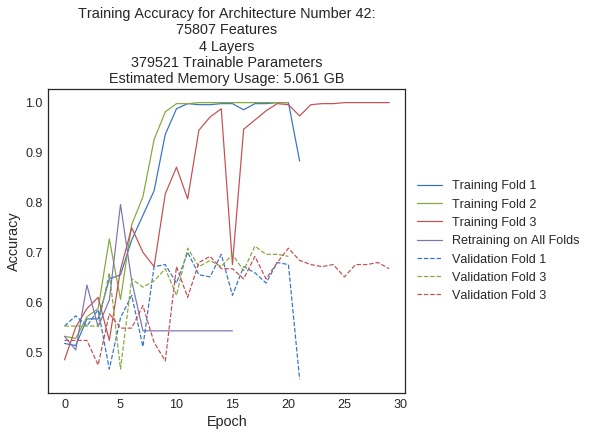

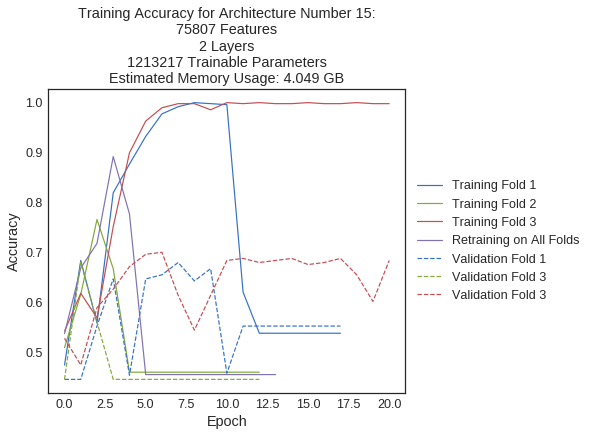

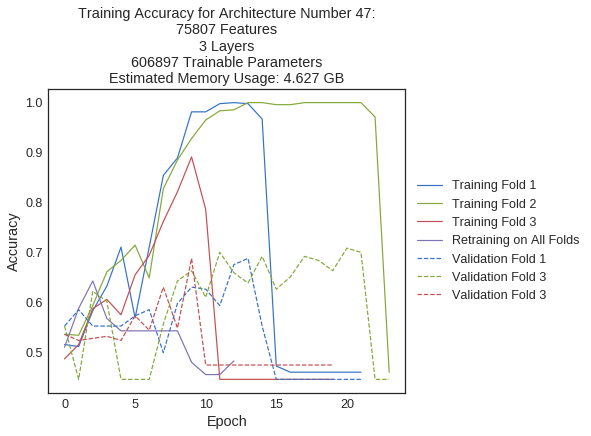

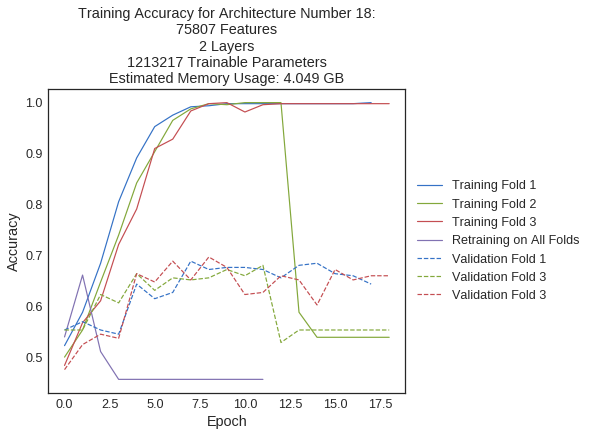

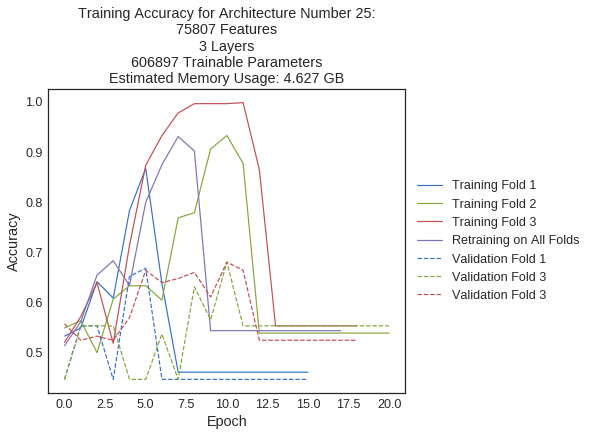

In [30]:
fPlot(lsModels, 'acc', dModelAccs, dModelTrainableParams)

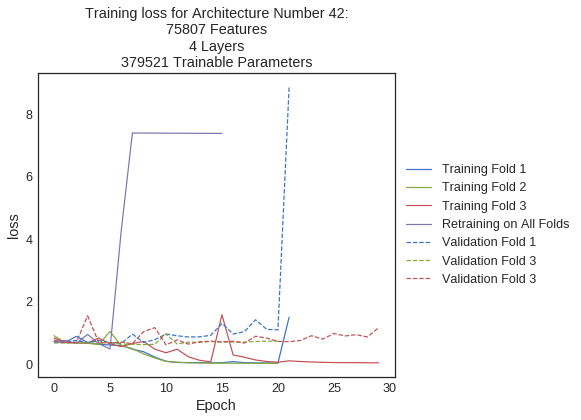

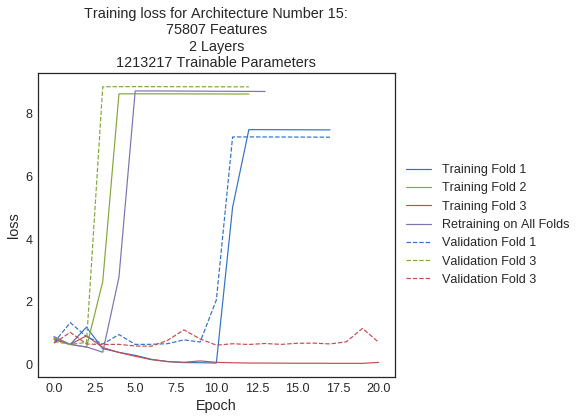

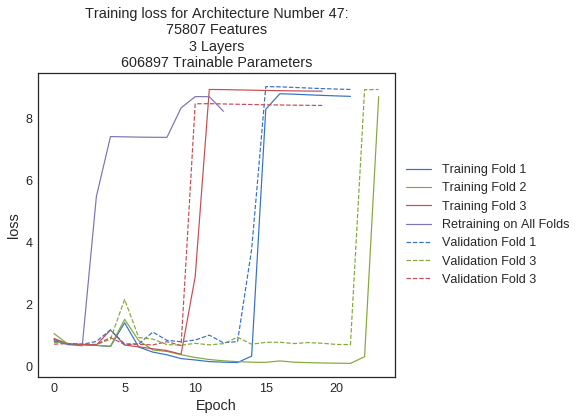

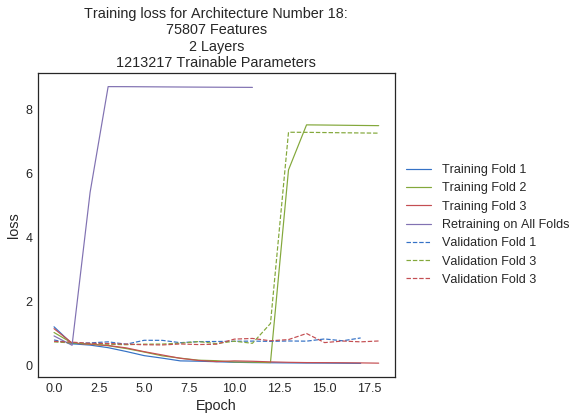

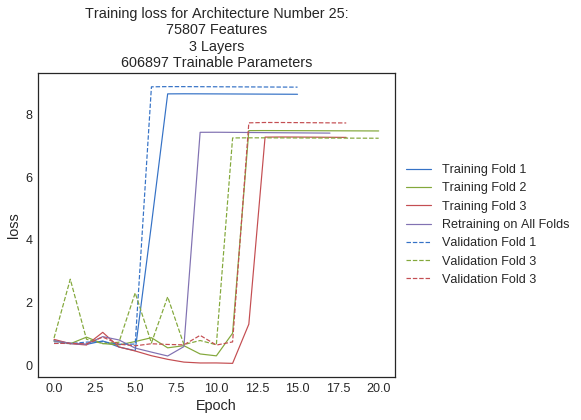

In [14]:
fPlot(lsModels, 'loss', dModelLoss, dModelTrainableParams)

In [15]:
CV1hist = pickle.load(open(sDataPath+'/Dense_'+str(iModel)+'AllAtlasesModelHistoryCrossVal1.p', 'rb'))

In [16]:
CV1hist.history['val_acc']

[0.4467213109868472,
 0.5532786865703395,
 0.5532786865703395,
 0.4467213109868472,
 0.6516393423080444,
 0.6680327849309953,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472,
 0.4467213109868472]

In [17]:
XTr, XTs, YTr, YTs = pickle.load(open('/project/bioinformatics/DLLab/Cooper/Code/AutismProject/TrainTestData.p', 'rb'))

In [18]:
XTr['anatomy'].shape, XTr['connectivity']['basc122'].shape, XTr['connectivity']['craddock_scorr_mean'].shape, XTr['connectivity']['harvard_oxford_cort_prob_2mm'].shape, XTr['connectivity']['msdl'].shape, XTr['connectivity']['power_2011'].shape

((732, 243), (732, 7503), (732, 31125), (732, 1176), (732, 780), (732, 34980))

In [19]:
243+7503+31125+1176+780+34980

75807

In [20]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [21]:
from Parallelization.IMPAC_DenseNetwork import fReproduceModel

In [22]:
def fPrintModelMem(sModel):
    sWeightsPath="/project/bioinformatics/DLLab/Cooper/Code/AutismProject/Parallelization/TrainedModels/AllAtlases/Dense_"+sModel+"_AllAtlasesweights.h5"
    model=fReproduceModel('AllAtlases', sModel, sWeightsPath, sSubInputName='', b2Atlas=False)
    gb=get_model_memory_usage(128, model)
    print('Model number ' + sModel + ' uses ' + str(gb) + ' GB of memory')

In [23]:
for i in range(len(lsModels)):
    sModel=str(lsModels[i])
    fPrintModelMem(sModel)

Model number 42 uses 5.061 GB of memory
Model number 15 uses 4.049 GB of memory
Model number 47 uses 4.627 GB of memory
Model number 18 uses 4.049 GB of memory
Model number 25 uses 4.627 GB of memory
